# JPEG Experiment Visualization

## Mounting Drive and Unzipping

In [1]:
# connect to GDrive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [11]:
 %%capture
# GitLab Code of this looks like that
!unzip /content/drive/MyDrive/ProtopNet/this-does-not-look-like-that.zip -d /content/

In [12]:
 %%capture
 # Unzip Test data set of CUB200
!unzip /content/drive/MyDrive/datasets/cub_200_test_images.zip -d /content/

In [13]:
 %%capture
 # Unzip Model weights
!unzip /content/drive/MyDrive/ProtopNet/jpeg_saved_models.zip -d /content/

## Import Modules

In [14]:
!pip install Augmentor

In [15]:
# External Imports
import os
import re
from io import BytesIO
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
import cv2
import sys
from tqdm import tqdm
import copy


# GitLab Code imports
sys.path.append("/content/this-does-not-look-like-that")
sys.path.insert(0, '/content/this-does-not-look-like-that/src/models/')
import src.training.train_and_test as tnt
from src.data.preprocess import mean, std
from settings import img_size, test_batch_size
from src.data.customdataset import CustomImageFolder
from src.utils.local_analysis import LocalAnalysis

# Random Seed
random_seed = 42
torch.manual_seed(random_seed)


## Prepare Data

In [16]:
# Directories
directory = "cub_200_test_images/cub200_cropped/"
directory_test = directory + "test_cropped/"

In [17]:
def JPEGcompression(image):
    """Applies JPEG compression of quality JPEG_QUALITY
    Args:
        image (PIL Image): uncompressed image
    Returns:
        Compressed Image
    """
    outputIoStream = BytesIO()
    image.save(outputIoStream, "JPEG", quality=JPEG_QUALITY, optimice=True)
    outputIoStream.seek(0)
    return Image.open(outputIoStream)

In [18]:
normalize = transforms.Normalize(mean=mean, std=std)


# Test data, where 50% of the images are uncompressed and the other 
# 50% of the images are compressed. It is processed in the CustomImageFolder class
test_dataset = CustomImageFolder(
    directory_test,
    transform= transforms.Compose([   
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]),
    target_specific_transform= transforms.Compose([
        transforms.Lambda(JPEGcompression) # Apply JPEG compression as transform
    ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False,
    num_workers=4, pin_memory=False)


# Test data, where are the images are uncompressed
test_dataset_all_clean = datasets.ImageFolder(
    directory_test,
    transforms.Compose([ 
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]))

test_loader_all_clean = torch.utils.data.DataLoader(
    test_dataset_all_clean, batch_size=test_batch_size, shuffle=False,
    num_workers=4, pin_memory=False)



## Load Network

Model Paths:

- ResNet18 - /content/jpeg_saved_models/resnet18/002/10_19push0.8019.pth
- ResNet34 - /content/jpeg_saved_models/resnet34/002/10_18push0.8214.pth
- VGG19 - /content/jpeg_saved_models/vgg19/002/10_9push0.7891.pth

In [22]:
# Select Network, and specify Experiment run
base_architecture = 'vgg19' #'resnet34', 'vgg19'
experiment_run = '002'

# Model directory
load_model_dir = '/content/jpeg_saved_models/{}/002/'.format(base_architecture)
load_model_name = '10_9push0.7891.pth'

# Specify the folder to save the images and logs
! mkdir -p /content/drive/MyDrive/PPNet/jpeg_analysis/{base_architecture}/{experiment_run}
save_dir = '/content/drive/MyDrive/PPNet/jpeg_analysis/' + base_architecture + '/' + experiment_run + '/'

In [23]:
loc_analysis = LocalAnalysis(load_model_dir, load_model_name, "", image_save_directory = save_dir)

load model from /content/jpeg_saved_models/vgg19/002/10_9push0.7891.pth
model base architecture: vgg19
experiment run: 002
Prototypes are chosen from 200 number of classes.
Their class identities are: [  0   0   0 ... 199 199 199]
All prototypes connect most strongly to their respective classes.


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set 

## Check Model Performance

In [24]:
JPEG_QUALITY = 20

protopnet = loc_analysis.ppnet_multi

print("Accuracy on test data set with half the classes being jpeg compressed and the other half uncompressed")
tnt.test(model=protopnet, dataloader=test_loader, 
         class_specific=loc_analysis.class_specific, 
         log=loc_analysis.log)
print("")

print("Accuracy on test data set with no jpeg compressed classes")
tnt.test(model=protopnet, dataloader=test_loader_all_clean, 
         class_specific=loc_analysis.class_specific, 
         log=loc_analysis.log)
print("")

Accuracy on test data set with half the classes being jpeg compressed and the other half uncompressed
	test
	time: 	35.14036226272583
	cross ent: 	1.0074392659910794
	cluster: 	0.04602164091092759
	separation:	0.043396999352964864
	avg separation:	1.4197443949765172
	accu: 		78.90921643079048%
	l1: 		10922.517578125
	p dist pair: 	3.1592905521392822

Accuracy on test data set with no jpeg compressed classes
	test
	time: 	67.71868944168091
	cross ent: 	2.5413488940945985
	cluster: 	0.08995880530183685
	separation:	0.04199820275193658
	avg separation:	1.4666898024493251
	accu: 		54.349326889886086%
	l1: 		10922.517578125
	p dist pair: 	3.1592905521392822



## Visualize and inspect the prototypes

## Visualize Prototypes

Predicted: 1	 Actual: 1	 Prediction is correct.
image index 0 in batch
protoype index: 15
prototype class identity: 1
activation value (similarity score): 5.123554229736328
------------------------------
Predicted: 1	 Actual: 1	 Prediction is correct.
image index 0 in batch
protoype index: 15
prototype class identity: 1
prototype connection identity: 1
activation value (similarity score): 1.5031183958053589
------------------------------


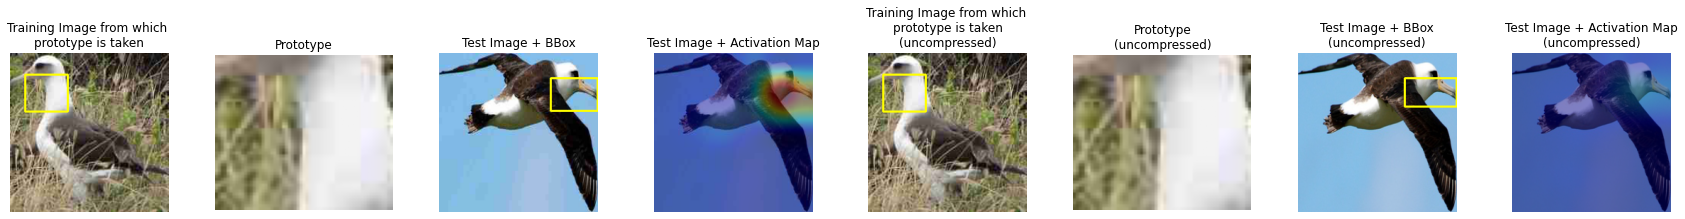



Predicted: 21	 Actual: 21	 Prediction is correct.
image index 0 in batch
protoype index: 217
prototype class identity: 21
activation value (similarity score): 3.294618606567383
------------------------------
Predicted: 21	 Actual: 21	 Prediction is correct.
image index 0 in batch
protoype index: 217
prototype class identity: 21
activation value (similarity score): 3.156545639038086
------------------------------


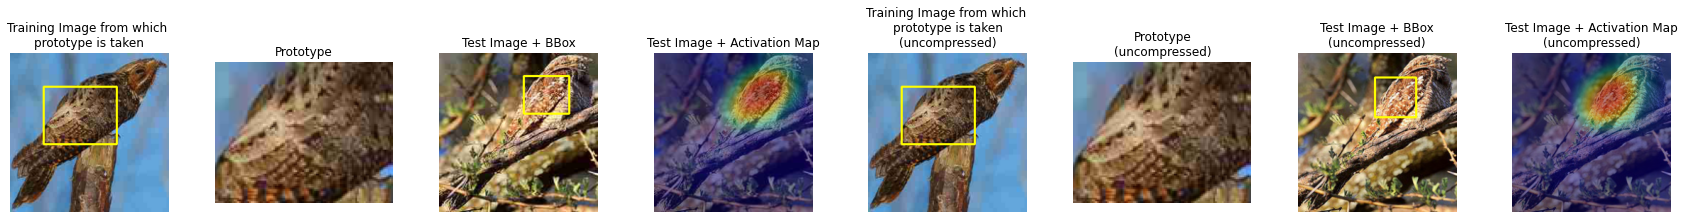



Predicted: 41	 Actual: 41	 Prediction is correct.
image index 0 in batch
protoype index: 415
prototype class identity: 41
activation value (similarity score): 7.2665910720825195
------------------------------
Predicted: 138	 Actual: 41	 Prediction is wrong.
image index 0 in batch
protoype index: 415
prototype class identity: 41
prototype connection identity: 41
activation value (similarity score): 4.227725505828857
------------------------------


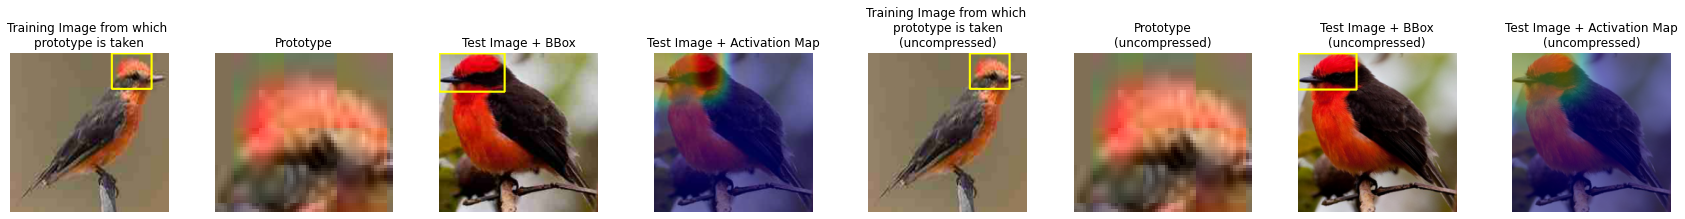



Predicted: 59	 Actual: 61	 Prediction is wrong.
image index 0 in batch
protoype index: 1834
prototype class identity: 183
activation value (similarity score): 3.321425676345825
------------------------------
Predicted: 58	 Actual: 61	 Prediction is wrong.
image index 0 in batch
protoype index: 1834
prototype class identity: 183
prototype connection identity: 183
activation value (similarity score): 1.9075733423233032
------------------------------


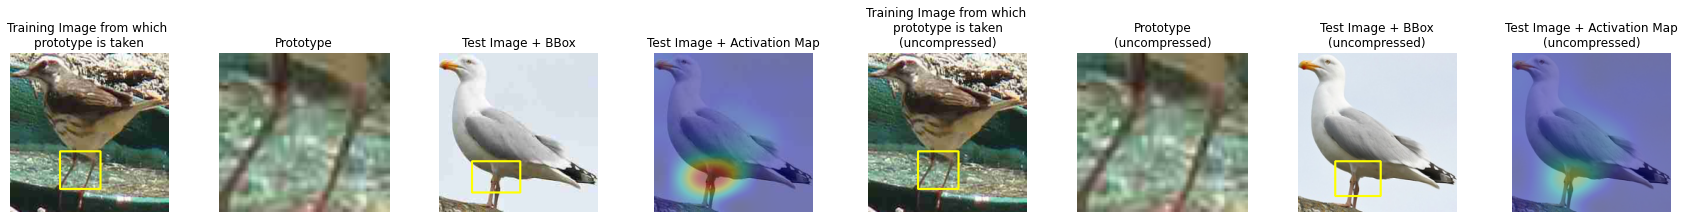



Predicted: 79	 Actual: 81	 Prediction is wrong.
image index 0 in batch
protoype index: 795
prototype class identity: 79
activation value (similarity score): 5.580388069152832
------------------------------
Predicted: 80	 Actual: 81	 Prediction is wrong.
image index 0 in batch
protoype index: 795
prototype class identity: 79
prototype connection identity: 79
activation value (similarity score): 1.6678187847137451
------------------------------


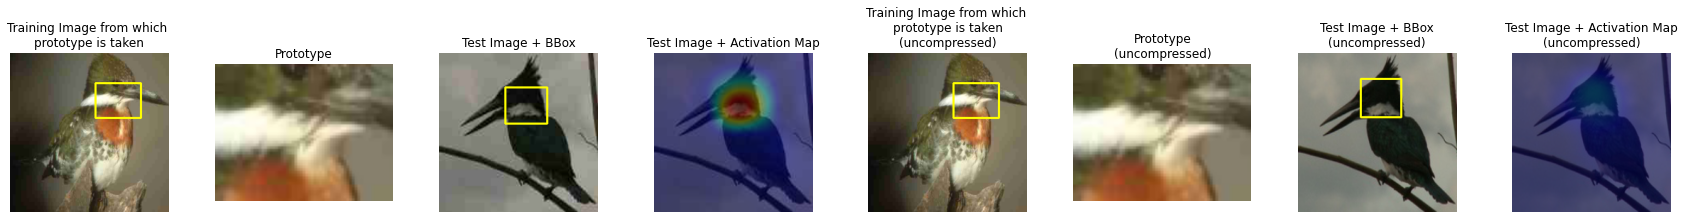



Predicted: 101	 Actual: 101	 Prediction is correct.
image index 0 in batch
protoype index: 395
prototype class identity: 39
activation value (similarity score): 4.9036970138549805
------------------------------
Predicted: 102	 Actual: 101	 Prediction is wrong.
image index 0 in batch
protoype index: 395
prototype class identity: 39
prototype connection identity: 39
activation value (similarity score): 2.4899098873138428
------------------------------


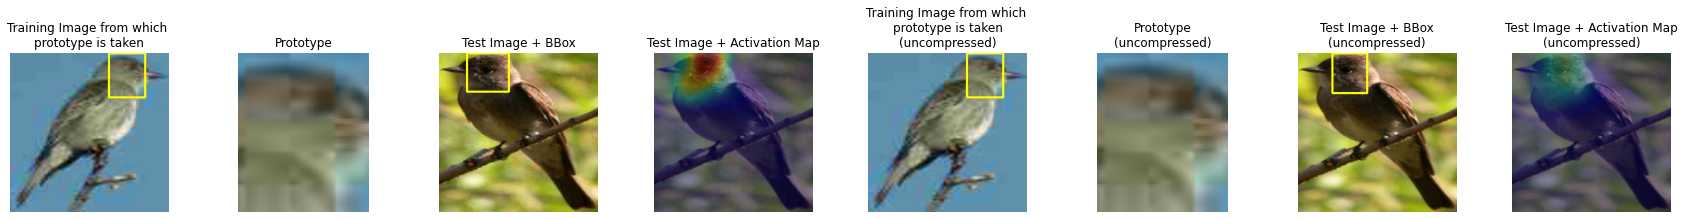



Predicted: 121	 Actual: 121	 Prediction is correct.
image index 0 in batch
protoype index: 1213
prototype class identity: 121
activation value (similarity score): 4.546549320220947
------------------------------
Predicted: 121	 Actual: 121	 Prediction is correct.
image index 0 in batch
protoype index: 1213
prototype class identity: 121
activation value (similarity score): 3.9527428150177
------------------------------


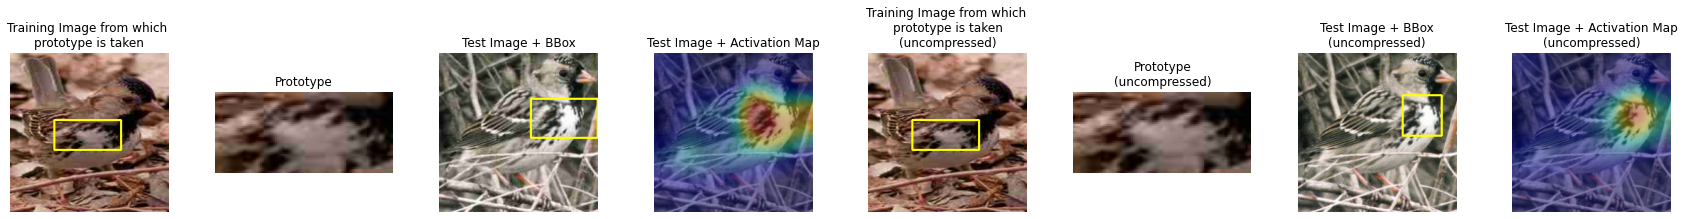



Predicted: 77	 Actual: 141	 Prediction is wrong.
image index 0 in batch
protoype index: 1715
prototype class identity: 171
activation value (similarity score): 3.8150713443756104
------------------------------
Predicted: 136	 Actual: 141	 Prediction is wrong.
image index 0 in batch
protoype index: 1715
prototype class identity: 171
prototype connection identity: 171
activation value (similarity score): 0.2260040044784546
------------------------------


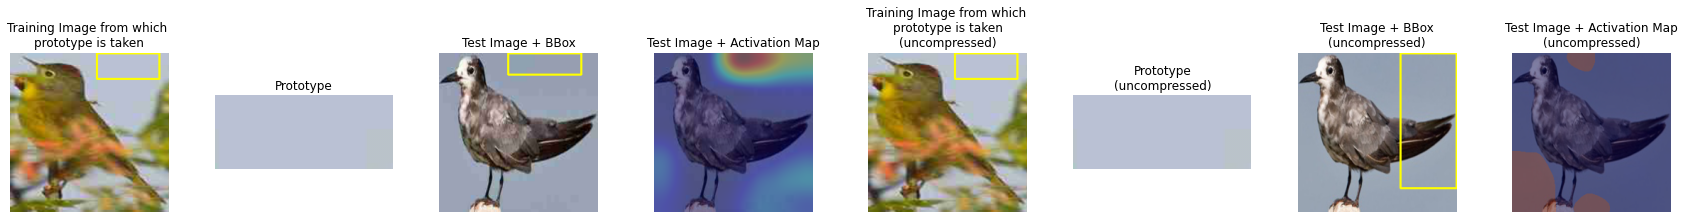



Predicted: 161	 Actual: 161	 Prediction is correct.
image index 0 in batch
protoype index: 875
prototype class identity: 87
activation value (similarity score): 4.677082538604736
------------------------------
Predicted: 161	 Actual: 161	 Prediction is correct.
image index 0 in batch
protoype index: 875
prototype class identity: 87
prototype connection identity: 87
activation value (similarity score): 2.6149282455444336
------------------------------


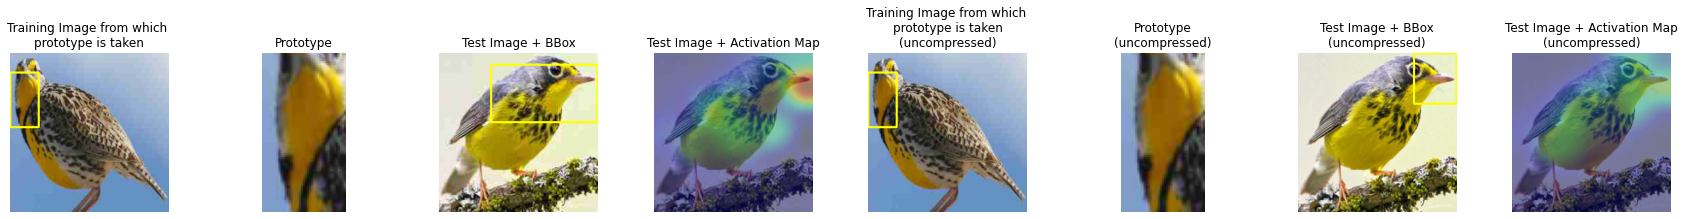



Predicted: 181	 Actual: 181	 Prediction is correct.
image index 0 in batch
protoype index: 1815
prototype class identity: 181
activation value (similarity score): 4.025467872619629
------------------------------
Predicted: 181	 Actual: 181	 Prediction is correct.
image index 0 in batch
protoype index: 1815
prototype class identity: 181
activation value (similarity score): 3.1657092571258545
------------------------------


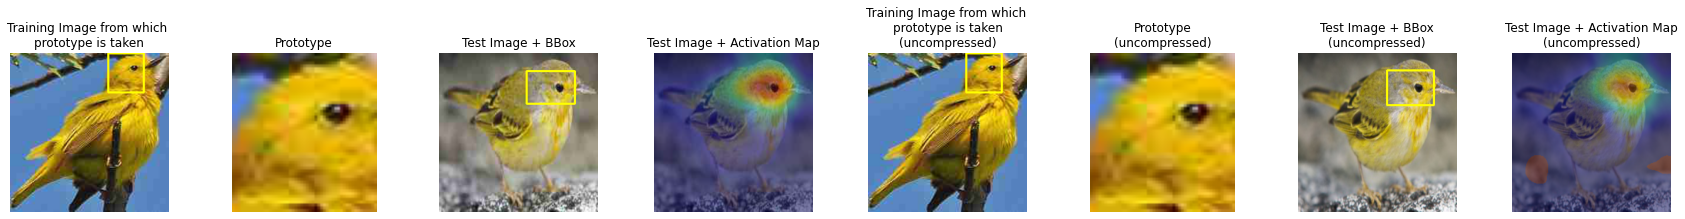

In [29]:
JPEG_QUALITY = 20

# Retrieve test data classes
classes = sorted(os.listdir(directory_test))

sample_images = 10

# Loop over every fourth class, which has also been compressed during training
for i in range(sample_images):
    test_image_label = (len(classes)//sample_images)*i+1
    test_image_dir = directory_test+classes[(len(classes)//sample_images)*i+1]
    image_list = os.listdir(test_image_dir)
    for j in range(1):
        test_image_path = os.path.join(test_image_dir, image_list[j])

        # Compression Processing Pipeline
        preprocess_corrupted = transforms.Compose([
                    transforms.Lambda(JPEGcompression),
                    transforms.Resize(size=(img_size, img_size)),
                    transforms.ToTensor(),
                    normalize,
                ])
        
        # Normal Processing Pipeline
        preprocess_clean = transforms.Compose([
                    transforms.Resize(size=(img_size, img_size)),
                    transforms.ToTensor(),
                    normalize,
                ])

        img_pil = Image.open(test_image_path)

        # Show the results
        loc_analysis.jpeg_visualization(img_pil, image_list[j].split(".")[0], test_image_label,
                                        preprocess_clean, preprocess_corrupted, 
                                        show_images=True)
        print("")
        print("")